MNE : From raw data to epochs and evoked responses (ERF/ERP)
============================================================

`
Authors:
Alexandre Gramfort
Denis A. Engemann
`

In [4]:
# add plot inline in the page
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

First, load the mne package:

In [5]:
import mne
mne.pick_types?

We set the log-level to 'WARNING' so the output is less verbose

In [6]:
mne.set_log_level('WARNING')

## Access raw data

Now we import the sample dataset. If you don't already have it, it will be downloaded automatically (but be patient approx. 2GB)

In [7]:
from mne.datasets import sample
data_path = sample.data_path()
# data_path = '/home/tutorial/MNE-sample-data'
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

print raw_fname

/Users/dengemann/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


In [8]:
print raw_fname

/Users/dengemann/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


Read data from file:

In [9]:
raw = mne.io.Raw(raw_fname)
print raw

<RawFIF  |  n_channels x n_times : 376 x 41700>


In [10]:
raw.ch_names[315:315 + 3]

['EEG 001', 'EEG 002', 'EEG 003']

In [11]:
print raw.info

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : dict | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : unicode | /Users/den.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 0.10000000149
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0
    meas_date : numpy.ndarray | 2002-12-03 20:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
 

Look at the channels in raw:

In [12]:
print raw.ch_names[:5]

['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123']


In [13]:
data, times = raw[:, :10]
print data.shape

(376, 10)


# plotting the hard way

Read and plot a segment of raw data

In [14]:
start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
data, times = raw[:306, start:stop]
print data.shape
print times.shape
print times.min(), times.max()

(306, 2252)
(2252,)
99.9975041858 114.988805013


In [15]:
# picks = mne.pick_types(raw.info, meg='mag', exclude=[])
# print pick

Take some magnetometer data and plot it

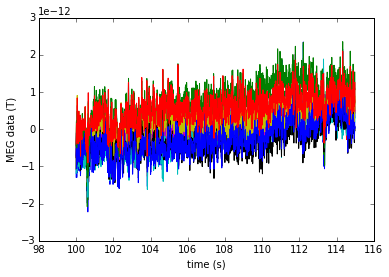

In [16]:
picks = mne.pick_types(raw.info, meg='mag', exclude=[])
data, times = raw[picks[:10], start:stop]

import matplotlib.pyplot as plt
plt.plot(times, data.T)
plt.xlabel('time (s)')
plt.ylabel('MEG data (T)')


# ... or use MNE plotters

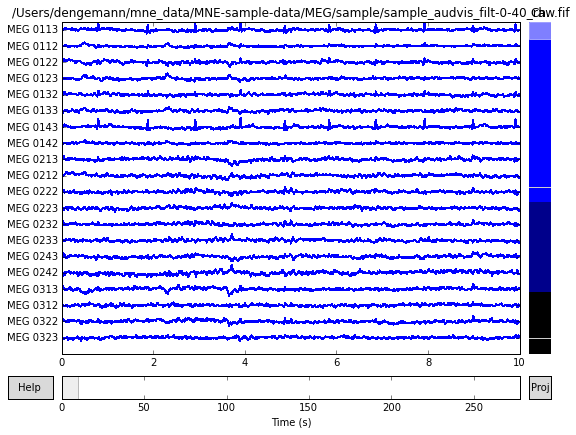

In [18]:
%matplotlib qt4

raw.plot();

In [19]:
len(mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads'))

59

In [20]:
raw.info['bads']

[u'MEG 2443', u'EEG 053']

Save a segment of 150s of raw data (MEG only):

In [21]:
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, exclude=[])
raw.save('sample_audvis_meg_raw.fif', tmin=0., tmax=150., picks=picks, overwrite=True)

Filtering:

In [22]:
raw_beta = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering

# keep beta band
raw_beta.filter(13.0, 30.0, method='iir')

# save the result
raw_beta.save('sample_audvis_beta_raw.fif', overwrite=True)

print raw_beta.info

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : dict | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : unicode | /Users/den.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 13.0
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 30.0
    meas_date : numpy.ndarray | 2002-12-03 20:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    hpi_su

## Exercise :

- Filter the raw data between 1Hz and 40Hz. Observe the absence of the slow drifts.
- Plot the magnetometers and the gradiometers separately. Observe the different units.

## Define and read epochs

First extract events:

In [23]:
events = mne.find_events(raw, stim_channel='STI 014')

In [24]:
print events[:5]  # events is a 2d array

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [25]:
len(events[events[:, 2] == 2])

73

In [26]:
len(events)

319

Where are they coming from?

In [27]:
d, t = raw[raw.ch_names.index('STI 014'), :]
d.shape

(1, 41700)

In [28]:
raw.ch_names.index('STI 014')

312

In [29]:
raw = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering
raw.filter(1, 40, method='iir')

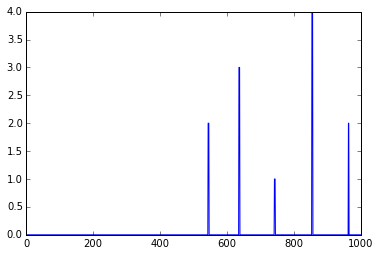

In [30]:
plt.plot(d[0,:1000])

Events are stored as 2D numpy array where the first column is the time instant and the last one is the event number. It is therefore easy to manipulate.

In [31]:
events_new = events.copy()
events_new[events_new[:, 2] == 2, 2] = 1  # matlab like syntax
events_new[events_new[:, 2] == 4, 2] = 3
print events_new[:5]
print events[:5]

[[6994    0    1]
 [7086    0    3]
 [7192    0    1]
 [7304    0    3]
 [7413    0    1]]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


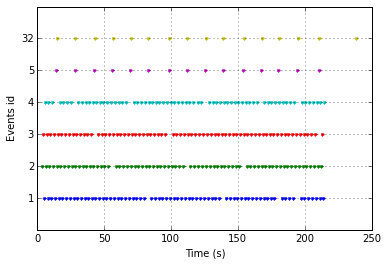

In [32]:
fig = mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp)

Define epochs parameters:

In [33]:
event_id = dict(aud_l=1, aud_r=2)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

In [34]:
event_id

{'aud_l': 1, 'aud_r': 2}

Mark 2 channels as bad:

In [35]:
raw.info['bads'] = ['MEG 2443', 'EEG 053']
print raw.info['bads']

['MEG 2443', 'EEG 053']


The variable raw.info[‘bads’] is just a python list.

Pick the good channels:

In [36]:
picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=True,
                       stim=False, exclude='bads')

Alternatively one can restrict to magnetometers or gradiometers with:

In [37]:
mag_picks = mne.pick_types(raw.info, meg='mag', eog=True, exclude='bads')
grad_picks = mne.pick_types(raw.info, meg='grad', eog=True, exclude='bads')

Define the baseline period:

In [38]:
baseline = (None, 0)  # means from the first instant to t = 0

Define peak-to-peak rejection parameters for gradiometers, magnetometers and EOG:

In [39]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

Read epochs:

In [40]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject)

In [41]:
# more MNE plotters ...

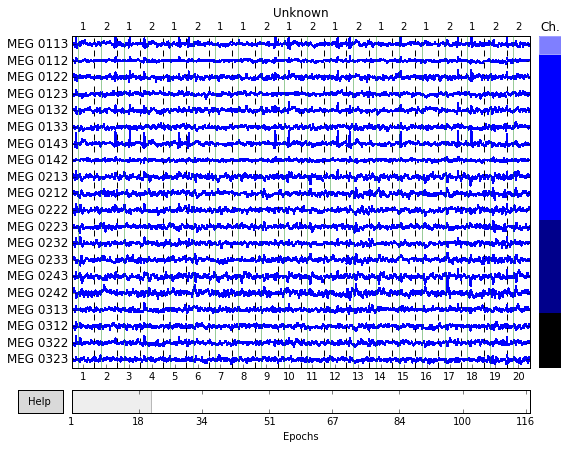

In [46]:
% matplotlib qt4
# *new* -- *GSOC 2015*

epochs.plot()

See what channels contribute to epochs rejection:

In [47]:
epochs.drop_bad_epochs()
epochs.plot_drop_log();

Scipy supports reading and writing of matlab files. You can save your single trials with:

In [48]:
from scipy import io
io.savemat('epochs_data.mat', dict(epochs_data=epochs.get_data()),
           oned_as='row')

or if you want to keep all the information about the data you can save your epochs in a fif file:

In [49]:
epochs.save('sample-epo.fif')

### Average the epochs to get ERF/ERP

In [50]:
evoked = epochs.average()

### Now let's visualize our ERP/ERF:

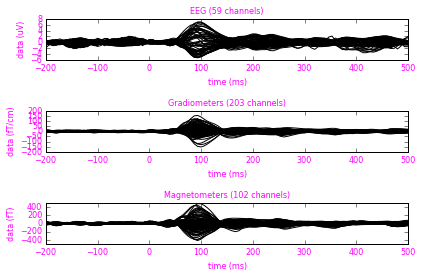

In [55]:
% matplotlib inline

fig = evoked.plot(show=False)  # butterfly plots
fig.subplots_adjust(hspace=1.0)
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(8)
    text.set_color('magenta')
fig.savefig('fede.pdf');

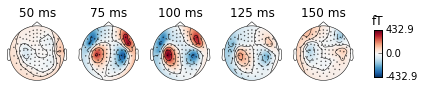

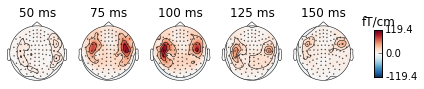

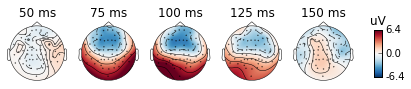

In [56]:
# topography plots
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag');
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='grad');
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='eeg');

### Get single epochs for one condition:

Syntax is `epochs[condition]`

In [57]:
epochs_data = epochs['aud_l'].get_data()
print epochs_data.shape

(55, 365, 106)


epochs_data is a 3D array of dimension (55 epochs, 365 channels, 106 time instants).

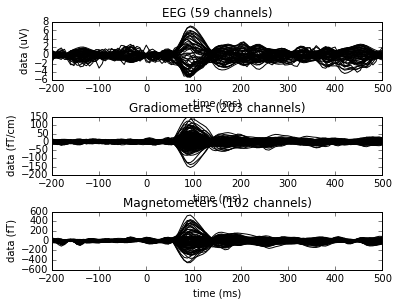

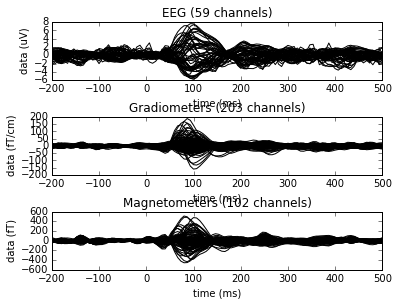

In [58]:
# Loop over conditions
for k in event_id:
    epochs[k].average().plot();

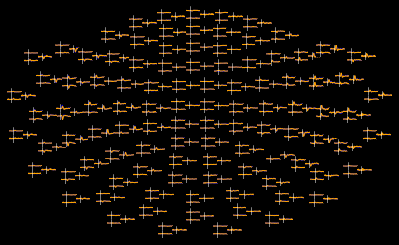

In [60]:
evokeds = [epochs[k].average() for k in event_id]
from mne.viz import plot_topo
layout = mne.find_layout(epochs.info)
plot_topo(evokeds, layout=layout, color=['blue', 'orange']);

### Write evoked data to disk

In [67]:
evoked.save('sample-ave.fif')

or to write multiple conditions in 1 file

In [68]:
mne.write_evokeds('sample-ave.fif', evokeds)

## Exercise:

- Recompute epochs and evoked on highpassed data without baseline. Is it different?

### Reading evoked from disk

It is also possible to read evoked data stored in a fif file:

In [69]:
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked1 = mne.read_evokeds(evoked_fname, condition=0, baseline=(None, 0), proj=True)

Or another one stored in the same file:

In [70]:
evoked2 = mne.read_evokeds(evoked_fname, condition=1,
                           baseline=(None, 0), proj=True)

Or give the explicit name of the averaged condition:

In [71]:
evoked3 = mne.read_evokeds(evoked_fname, condition='Left visual',
                           baseline=(None, 0), proj=True)

### Compute a contrast:

In [72]:
contrast = evokeds[0] - evokeds[1]
print contrast

<Evoked  |  comment : 'aud_r - aud_l', time : [-0.199795, 0.499488], n_epochs : 116, n_channels x n_times : 364 x 106>


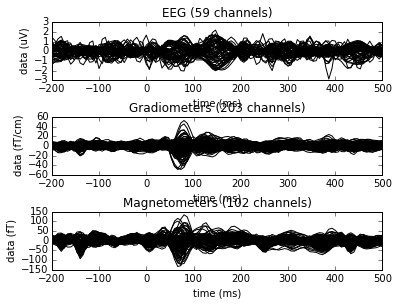

In [ ]:
fig = contrast.plot()

### Save your figure as pdf

In [ ]:
# will only work on MAC
%matplotlib qt4
import numpy as np
contrast.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag')
plt.savefig('toto.pdf')
!open toto.pdf

## Excercise
- Extract Epochs restricted to magnetometers on unfiltered data (sample_audvis_raw.fif)
- What is the effect of setting proj=True or proj=False in Epochs?
- Add ECG projections to raw with raw.add_proj. Do you get rid of ECG?

In [56]:
raw.add_proj?